### Train a multilayer Perceptron using Lightning Trainer
https://lightning.ai/courses/deep-learning-fundamentals/overview-organizing-your-code-with-pytorch-lightning/5-2-training-a-multilayer-perceptron-using-the-lightning-trainer/

In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import dataset, DataLoader
from torchvision import datasets, transforms

#### Load dataset

In [2]:
train_dataset = datasets.MNIST(root='./dataset/mnist', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./dataset/mnist', train=False, transform=transforms.ToTensor())

In [3]:
train_dataset, val_dataset = dataset.random_split(train_dataset, [55000, 5000])
print(f'size of train: {len(train_dataset)} \nsize of val: {len(val_dataset)}')

size of train: 55000 
size of val: 5000


In [4]:
def get_data_loaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

#### Examine labels distribution

In [5]:
from collections import Counter

train_dataloader, val_dataloader, test_dataloader = get_data_loaders(batch_size=64)

train_counter = Counter()
for batch_features, labels in train_dataloader:
    train_counter.update(labels.tolist())

print(sorted(train_counter.items()))

[(0, 5468), (1, 6196), (2, 5484), (3, 5652), (4, 5282), (5, 5008), (6, 5444), (7, 5728), (8, 5320), (9, 5418)]


In [6]:
most_common_label = train_counter.most_common(1)[0]
basline_acc = most_common_label[1] / sum(train_counter.values())
print(f'baseline accuracy: {basline_acc*100 :.02f}$')

baseline accuracy: 11.27$


#### Training

In [7]:
import lightning
from lightning.pytorch.loggers import CSVLogger
import torch
import torch.nn.functional as F
import torchmetrics

In [8]:
class PytorchMnistMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        
        layer1_outputs = 50
        layer2_outputs = 25
        
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(num_features, layer1_outputs),
            torch.nn.ReLU(),

            torch.nn.Linear(layer1_outputs, layer2_outputs),
            torch.nn.ReLU(),

            torch.nn.Linear(layer2_outputs, num_classes)
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.layers(x)
        return logits

In [9]:
class LightningMLP(lightning.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

        # save hyperparameters (but skip the model parameters)
        self.save_hyperparameters(ignore=['model'])

        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10) # hardcode?
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)

    def forward(self, x):
        return self.model(x)
    
    def _process_step(self, batch, batch_idx):
        batch_features, batch_labels = batch
        logits = self.forward(batch_features)
        loss = F.cross_entropy(logits, batch_labels)
        predictions = torch.argmax(logits, dim=1)
        return loss, predictions, batch_labels
    
    def training_step(self, batch, batch_idx):
        loss, predictions, labels = self._process_step(batch, batch_idx)
        self.log("train_loss", loss)
        self.train_acc(predictions, labels)
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, predictions, labels = self._process_step(batch, batch_idx)
        self.log("val_loss", loss)
        self.val_acc(predictions, labels)
        self.log('val_acc', self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, predictions, labels = self._process_step(batch, batch_idx)
        self.log("test_loss", loss)
        self.val_acc(predictions, labels)
        self.log('test_acc', self.val_acc, prog_bar=True)

    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.learning_rate)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

torch.manual_seed(1)

train_dataloader, val_dataloader, test_dataloader = get_data_loaders(batch_size=64)

pytorch_mnist_model = PytorchMnistMLP(num_features=784, num_classes=10)
lightning_model = LightningMLP(pytorch_mnist_model, 0.05)

trainer = lightning.Trainer(
    max_epochs=10, 
    accelerator='auto', 
    devices=1,
    deterministic=True)

trainer.fit(model=lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

test_acc = trainer.test(dataloaders=test_dataloader)[0]['accuracy']

print(f"""
test accuracy: {test_acc}
""")

#### Organize Data Loaders with Data Modules

In [ ]:
class MnistDataModule(lightning.LightningDataModule):
    def __init__(self, data_dir='dataset/mnist', batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
    
    def prepare_data(self):
        # download
        datasets.MNIST(root=self.data_dir, train=True, transform=transforms.ToTensor(), download=True)
        datasets.MNIST(root=self.data_dir, train=False, transform=transforms.ToTensor(), download=True)
    
    # for multi GPUs
    def setup(self, stage: str):
        self.test_dataset = datasets.MNIST(root=self.data_dir, train=False, transform=transforms.ToTensor(), download=False)
        the_train_dataset = datasets.MNIST(root=self.data_dir, train=True, transform=transforms.ToTensor(), download=False)
        self.train_dataset, self.val_dataset = dataset.random_split(the_train_dataset, [55000, 5000])
        self.predict_dataset = datasets.MNIST(root=self.data_dir, train=False, transform=transforms.ToTensor(), download=False) # ?
    
    def train_dataloader(self):
        return DataLoader(dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(dataset=self.val_dataset, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(dataset=self.test_dataset, batch_size=self.batch_size)
    
    def predict_dataloader(self):
        return DataLoader(dataset=self.predict_dataset, batch_size=self.batch_size)

In [ ]:
mnist_datamodule = MnistDataModule(batch_size=64)
model = LightningMLP(PytorchMnistMLP(num_features=784, num_classes=10), 0.05)

trainer = lightning.Trainer(
    max_epochs=10, 
    accelerator='auto', 
    devices=1, 
    deterministic=True,
    logger=CSVLogger(save_dir='lightning_logs', name='csv') # so, not use TensorBoard
)

trainer.fit(model=model, datamodule=mnist_datamodule)
# save the model checkpoint so can load it later
trainer.save_checkpoint('checkpoints/mnist_classifier.ckpt')
# LightningMLP.load_from_checkpoint('mnist_model.ckpt', model=pytorch_mnist_model)

test_acc = trainer.test(datamodule=mnist_datamodule)
val_acc = trainer.validate(datamodule=mnist_datamodule)
# predict_acc = trainer.predict(datamodule=mnist_datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PytorchMnistMLP    | 40.8 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
-------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/tu/.local/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/tu/.local/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/tu/.local/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at lightning_logs/csv/version_3/checkpoints/epoch=9-step=8600.ckpt
Loaded model weights from the checkpoint at lightning_logs/csv/version_3/checkpoints/epoch=9-step=8600.ckpt
/home/tu/.local/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.967199981212616
        test_loss           0.10500697046518326
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/tu/.local/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at lightning_logs/csv/version_3/checkpoints/epoch=9-step=8600.ckpt
Loaded model weights from the checkpoint at lightning_logs/csv/version_3/checkpoints/epoch=9-step=8600.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9761999845504761
        val_loss            0.08445537090301514
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#### Visualize metrics from CSV logger

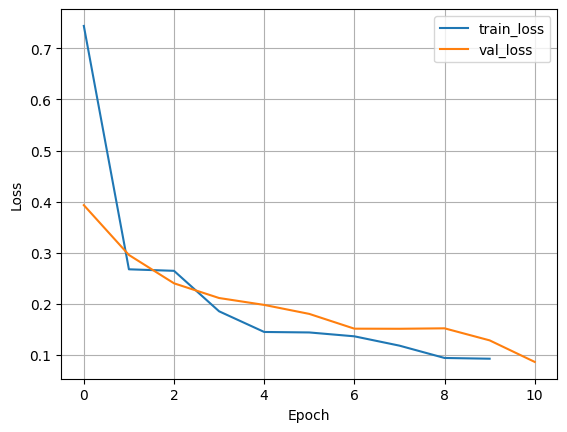

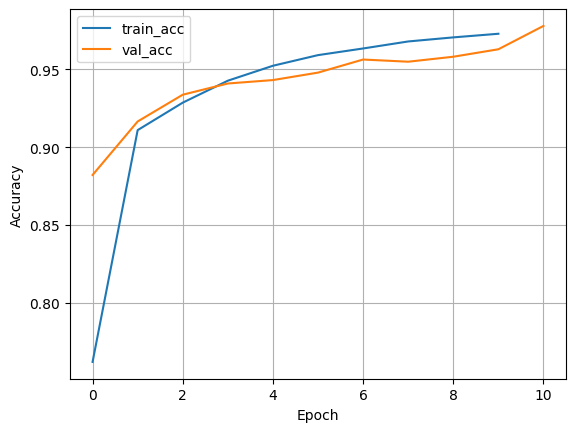

In [ ]:
import matplotlib.pyplot as plt

df_metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
df_metrics.head()
df_metrics_aggr = df_metrics.groupby(['epoch']).mean()

df_metrics_aggr[['train_loss', 'val_loss']].plot(grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics_aggr[['train_acc', 'val_acc']].plot(grid=True, legend=True, xlabel='Epoch', ylabel='Accuracy')
plt.show()


#### Load model from checkpoint

In [ ]:
pytorch_mnist_model = PytorchMnistMLP(num_features=784, num_classes=10)
lightning_model = LightningMLP.load_from_checkpoint('checkpoints/mnist_classifier.ckpt', model=pytorch_mnist_model)
lightning_model # something wrong with the model?

TypeError: __init__() missing 1 required positional argument: 'learning_rate'